In [40]:
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import joypy
from sklearn.metrics import f1_score, roc_auc_score, jaccard_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Load the image and labels.

In [2]:
train_img = np.array(Image.open('Training_Samples/region_14_clipped.tif'))
train_label = np.array(Image.open('Training_Samples/region_14_clipped_label.tif'))
train_img.shape

(769, 864, 4)

Put information of each pixel as a row into a dataframe.

In [3]:
def find_area(img, x, y, d=1):
    return img[max(0, x-d):x+d+1, max(0, y-d):y+d+1].astype(int)

def get_ndvi_around(area):
    ndvi = []
    n = len(area) * len(area[0])
    for row in area:
        for pix in row:
            ndvi.append((pix[3] - pix[0]) / (pix[3] + pix[0]) if pix[3] + pix[0] else 0)
    return ndvi

In [4]:
x = pd.DataFrame({'x': range(0, len(train_img))})
y = pd.DataFrame({'y': range(0, len(train_img[0]))})

df = x.assign(foo = 1).merge(y.assign(foo = 1), on = 'foo').drop(columns = ['foo'])

In [5]:
# Extract the basic information of each pixel, which contains r, g, b, NIR and NDVI.
df[['r', 'g', 'b', 'NIR']] = pd.DataFrame(df.apply(
    lambda x:train_img[int(x['x']), int(x['y'])].astype(int), axis = 1).tolist())

df['NDVI'] = df.apply(
    lambda x: (x['NIR']-x['r']) / (x['NIR']+x['r']) if x['NIR']+x['r'] else 0, axis = 1)

# Extract the information of surrounding pixels ofeach pixel, including min, max, average, std of basic information.
df[['r_avg', 'g_avg', 'b_avg', 'NIR_avg']] = pd.DataFrame(
    df.apply(lambda x:np.average(find_area(train_img, int(x['x']), int(x['y']), 2), axis = (0,1)), axis = 1).tolist())

df[['r_std', 'g_std', 'b_std', 'NIR_std']] = pd.DataFrame(
    df.apply(lambda x:np.std(find_area(train_img, int(x['x']), int(x['y']), 2), axis = (0,1)), axis = 1).tolist())

df['NDVI_min'] = df.apply(
    lambda x: np.min(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

df['NDVI_max'] = df.apply(
    lambda x: np.max(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

df['NDVI_avg'] = df.apply(
    lambda x: np.average(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

df['NDVI_std'] = df.apply(
    lambda x: np.std(get_ndvi_around(find_area(train_img, int(x['x']), int(x['y']), 2))), axis = 1)

In [9]:
df[100000:100100]

,x,y,r,g,b,NIR,NDVI,r_avg,g_avg,b_avg,NIR_avg,r_std,g_std,b_std,NIR_std,NDVI_min,NDVI_max,NDVI_avg,NDVI_std
100000,115,640,171,131,112,164,-0.020896,170.56,133.16,112.68,163.88,1.471870,1.591980,0.968297,1.750885,-0.030303,-0.011976,-0.019983,0.004496
100001,115,641,171,135,112,166,-0.014837,170.52,133.36,112.84,164.28,1.499867,1.520000,0.880000,1.637559,-0.030303,-0.011976,-0.018643,0.004359
100002,115,642,169,133,113,165,-0.011976,170.40,133.08,112.44,164.60,1.414214,1.440000,1.202664,1.469694,-0.023952,-0.011834,-0.017316,0.003056
100003,115,643,170,134,113,165,-0.014925,169.72,132.60,112.28,163.88,1.371714,1.496663,1.281249,1.750885,-0.023952,-0.011834,-0.017518,0.003081
100004,115,644,169,132,113,163,-0.018072,169.32,131.80,111.92,163.36,1.713943,1.788854,1.197330,2.017523,-0.023952,-0.011834,-0.017928,0.002941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100095,115,735,139,102,94,125,-0.053030,140.36,101.72,92.72,126.52,3.416197,2.391987,1.371714,3.971096,-0.067669,-0.040000,-0.051955,0.007004
100096,115,736,135,99,93,118,-0.067194,140.00,101.16,92.16,126.60,3.310589,2.292248,1.540909,3.898718,-0.067669,-0.037037,-0.050358,0.008224
100097,115,737,139,100,93,124,-0.057034,139.32,100.60,91.44,127.28,3.094770,2.349468,1.675231,3.975123,-0.067194,-0.018727,-0.045279,0.010788
100098,115,738,142,101,91,131,-0.040293,134.04,100.20,90.68,131.40,10.447890,2.297825,1.642437,9.612492,-0.067194,0.166052,-0.009716,0.071677


Clean up the tree labels.

In [11]:
train_label.shape

(769, 864)

In [12]:
# Add tree label to each pixel and label the row with positive label and NDVI value greater than 0.3 as 2.
def add_label(x, y):
    label = train_label[x, y]
    if label == 1 and df[(df.x == x) & (df.y == y)]['NDVI'].iloc[0] < 0.3:
        return 2
    return label

df['label'] = df.apply(lambda x: add_label(int(x['x']), int(x['y'])), axis=1)

In [13]:
# Drop the rows with label 2.
# df = df[df['label'] != 2]

EDAV

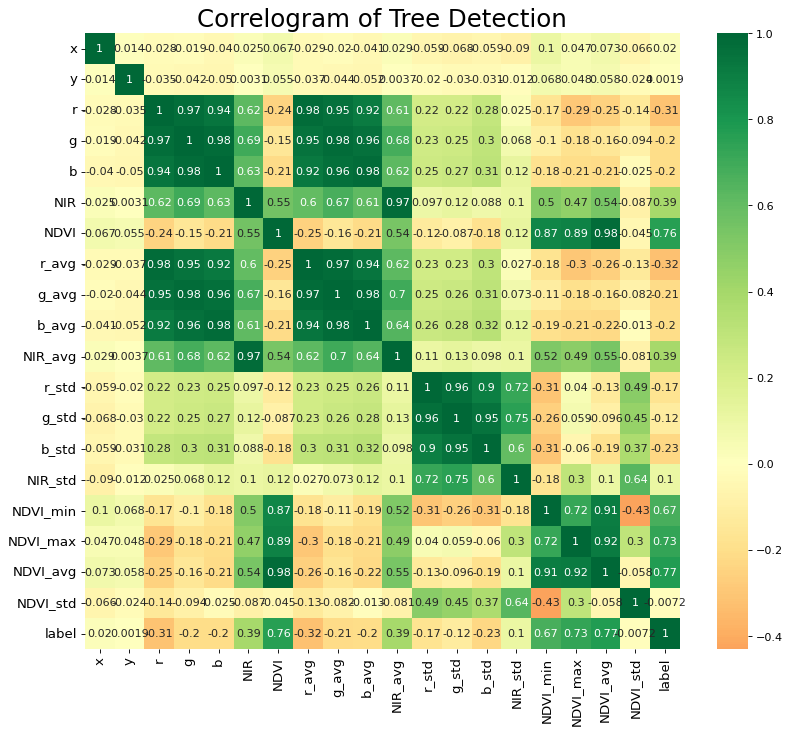

In [14]:
df_t = df[df['label'] != 2]
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df_t.corr(), xticklabels=df_t.corr().columns, yticklabels=df_t.corr().columns, cmap='RdYlGn', center=0, annot=True)

plt.title('Correlogram of Tree Detection', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The most important fact we could notice from the correlogram above is the label has highest correlation with NDVI and NDVI_avg.

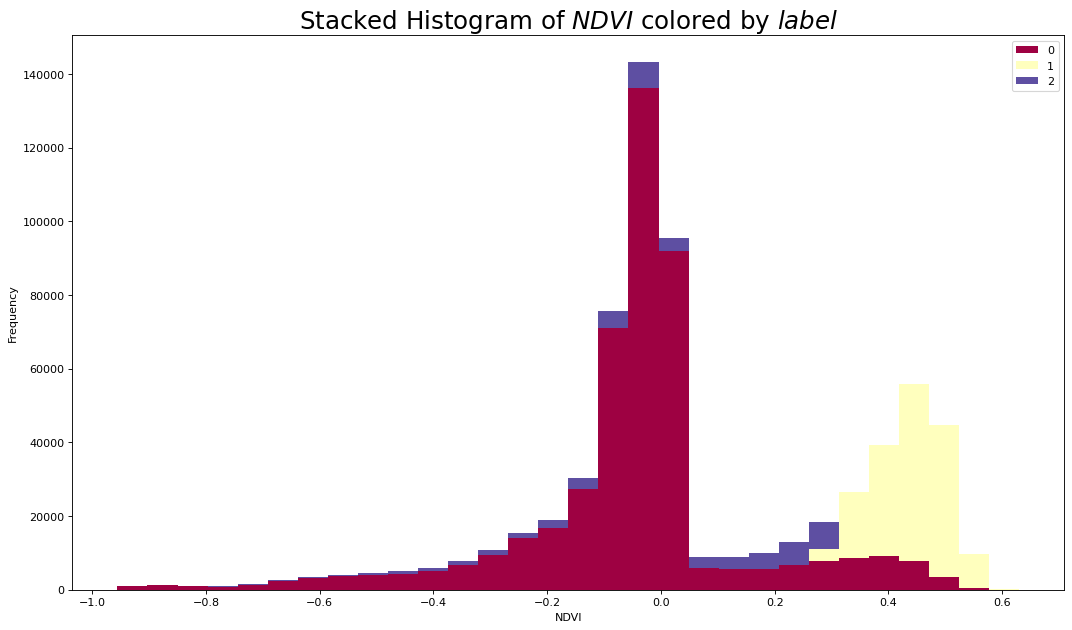

In [15]:
# Prepare data
x_var = 'NDVI'
groupby_var = 'label'
df_agg = df.loc[:, [x_var, groupby_var]].groupby(groupby_var)
vals = [df[x_var].values.tolist() for i, df in df_agg]

plt.figure(figsize=(16,9), dpi= 80)
colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

# Decoration
plt.legend({group:col for group, col in zip(np.unique(df[groupby_var]).tolist(), colors[:len(vals)])})
plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Frequency")
plt.show()

/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/3430631059.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/3430631059.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 1, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/3430631059.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 2, "NDVI"], shade=True, color="dodgerblue", label="Fal

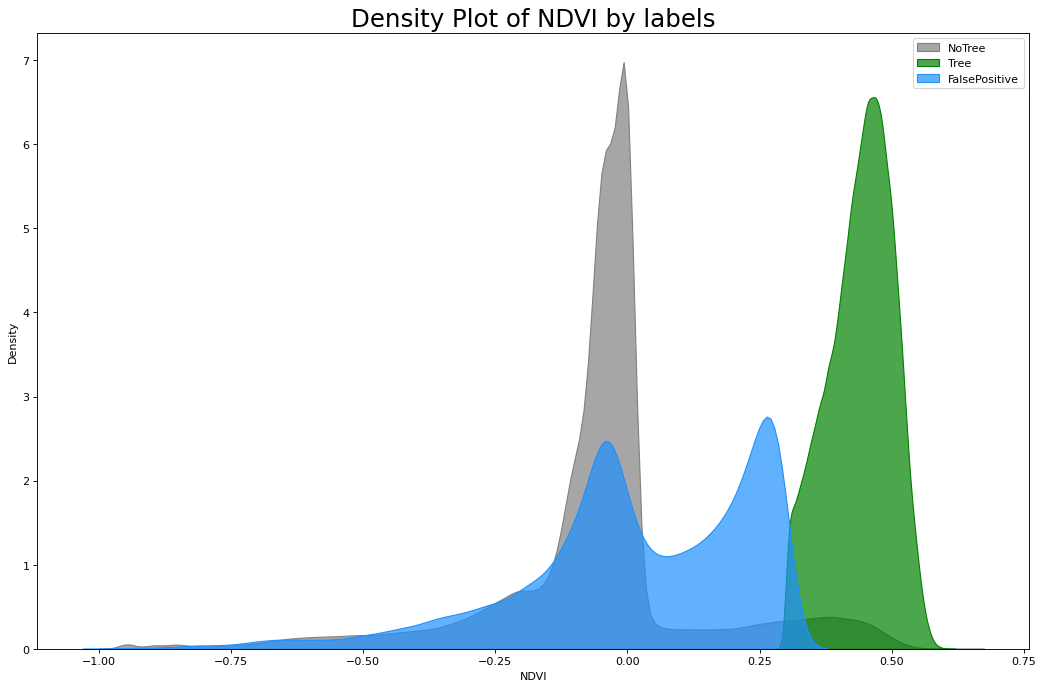

In [16]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
sns.kdeplot(df.loc[df['label'] == 1, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)
sns.kdeplot(df.loc[df['label'] == 2, "NDVI"], shade=True, color="dodgerblue", label="FalsePositive", alpha=.7)

# Decoration
plt.title('Density Plot of NDVI by labels', fontsize=22)
plt.legend()
plt.show()

/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/198266346.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/198266346.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['label'] > 0, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)


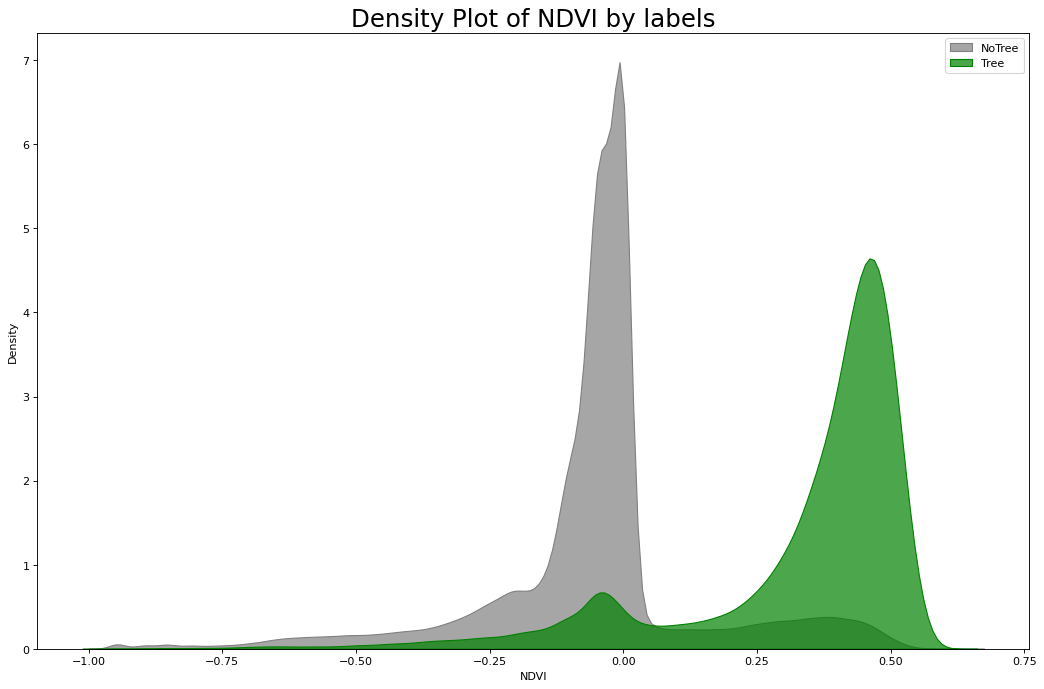

In [17]:
# Draw Plot
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(df.loc[df['label'] == 0, "NDVI"], shade=True, color="grey", label="NoTree", alpha=.7)
sns.kdeplot(df.loc[df['label'] > 0, "NDVI"], shade=True, color="green", label="Tree", alpha=.7)

# Decoration
plt.title('Density Plot of NDVI by labels', fontsize=22)
plt.legend()
plt.show()

<Figure size 1600x1000 with 0 Axes>

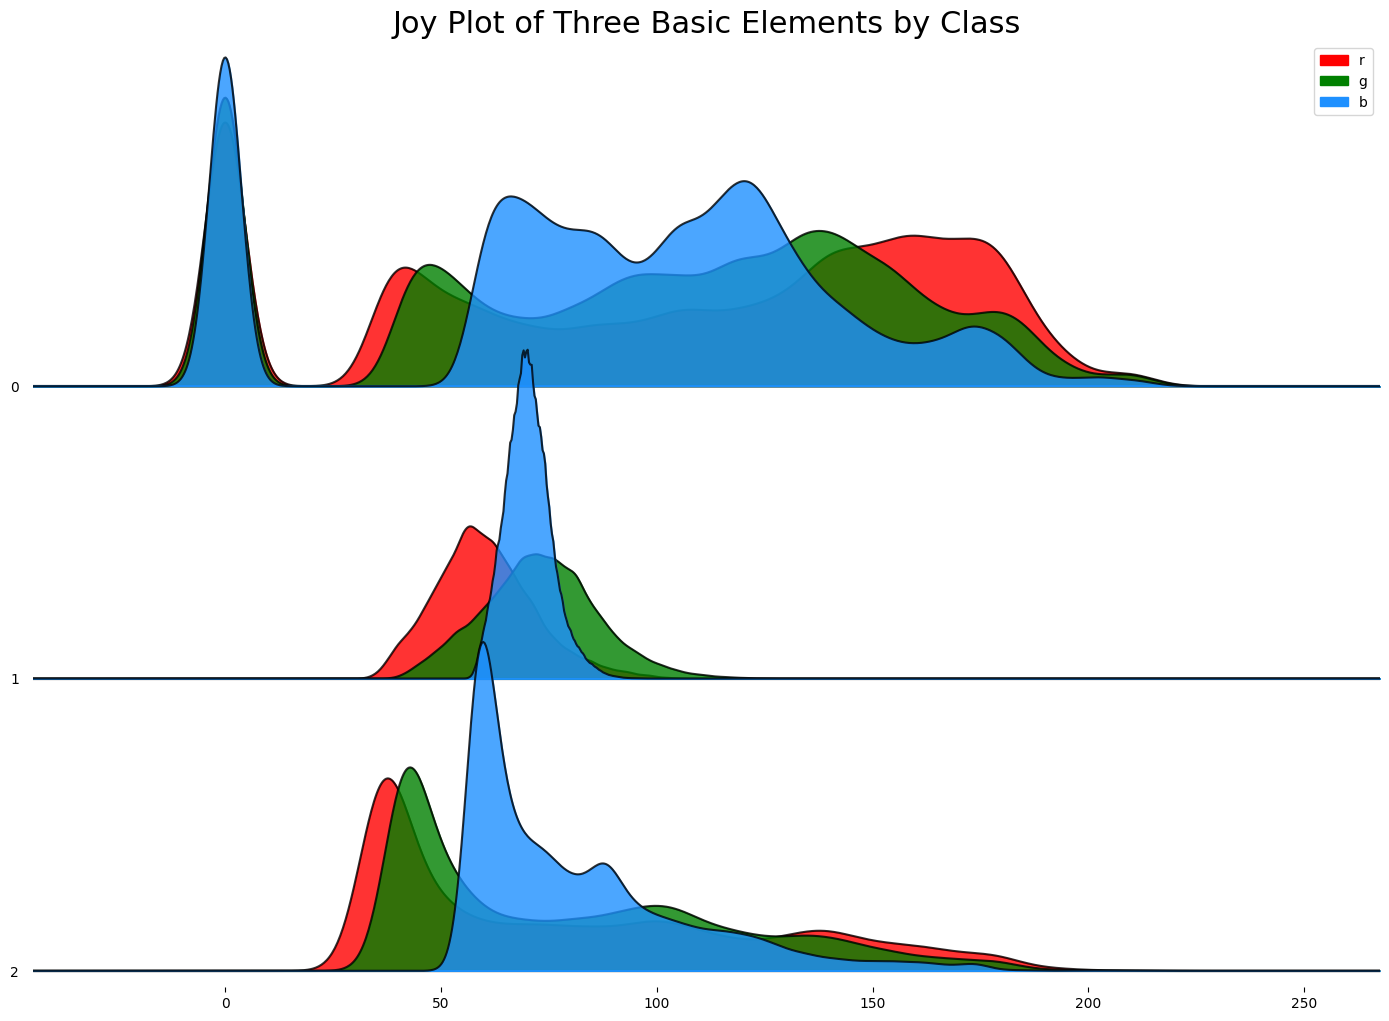

In [18]:
# Draw Plot
plt.figure(figsize=(16,10))
fig, axes = joypy.joyplot(df, column=['r', 'g', 'b'], color=['red', 'green', 'dodgerblue'], by="label", ylim='own', figsize=(14,10), legend=True, alpha=0.8)

# Decoration
plt.title('Joy Plot of Three Basic Elements by Class', fontsize=22)
plt.rc("font", size=20)
plt.show()

Training with random forest

In [19]:
# Drop the rows with label 2.
df = df[df['label'] != 2]

In [20]:
X = df.drop(columns=['label'])
y = df['label']

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
rf = RandomForestClassifier()
rf.fit(X_dev, y_dev)
y_pred = rf.predict(X_test)
print('accuracy on the test set-> {}'.format(sum(y_pred == y_test) / y_test.shape[0]))

accuracy on the test set-> 0.9714919252936812


In [30]:
print('f1 score on the test set-> {}'.format(f1_score(y_pred, y_test)))

f1 score on the test set-> 0.9434261401323346


In [37]:
print('AUC score on the test set-> {}'.format(roc_auc_score(y_pred, y_test)))

f1 score on the test set-> 0.9527655015720724


In [41]:
print('IoU score on the test set-> {}'.format(jaccard_score(y_pred, y_test)))

IoU score on the test set-> 0.8929107334252029


Training with Logistic Regression.

In [31]:
#Convert the label from a Pandas series to a Numpy (m x 1) vector.
y = np.array(y)

#Split the dataset.
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Standardize the columns.
scaler = StandardScaler()
X_dev = scaler.fit_transform(X_dev)   # Fit and transform scalar on X_train
X_test = scaler.transform(X_test)         # Transform X_test

#Add a column of ones to the feature matrices.
X_dev = np.hstack([np.ones((X_dev.shape[0], 1)), X_dev])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

In [32]:
class LogisticRegression():
    '''
    Logistic regression model with L2 regularization.

    Attributes
    ----------
    alpha: regularization parameter
    t: number of epochs to run gradient descent
    eta: learning rate for gradient descent
    w: (n x 1) weight vector
    '''
      
    def __init__(self, alpha=0, t=100, eta=1e-3):
        self.alpha = alpha
        self.t = t
        self.eta = eta
        self.w = None

    def train(self, X, y):
        '''Trains logistic regression model using gradient descent 
        (sets w to its optimal value).
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        losses: (t x 1) vector of losses at each epoch of gradient descent
        '''
        self.w = np.zeros(X.shape[1])  
        losses = []
        for i in range(self.t):
            self.w -= self.eta * self.calculate_gradient(X,y) 
            losses.append(self.calculate_loss(X,y))
        return losses
        
    def predict(self, X):
        '''Predicts on X using trained model. Make sure to threshold 
        the predicted probability to return a 0 or 1 prediction.
        
        Parameters
        ----------
        X : (m x n) feature matrix
        
        Returns
        -------
        y_pred: (m x 1) 0/1 prediction vector
        '''       
        sig = self.calculate_sigmoid(np.dot(X, self.w))
        y_pred = sig >= 0.5
        return y_pred
    
    def calculate_loss(self, X, y):
        '''Calculates the logistic regression loss using X, y, w, 
        and alpha. Useful as a helper function for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        loss: (scalar) logistic regression loss
        '''
        sig = self.calculate_sigmoid(np.dot(X, self.w))
        loss = np.dot(np.transpose(-y), np.log(sig)) - np.dot(np.transpose(1 - y), np.log(1-sig)) + self.alpha * np.dot(self.w, self.w)
        return loss
        
    
    def calculate_gradient(self, X, y):
        '''Calculates the gradient of the logistic regression loss 
        using X, y, w, and alpha. Useful as a helper function 
        for train().
        
        Parameters
        ----------
        X : (m x n) feature matrix
        y: (m x 1) label vector
        
        Returns
        -------
        gradient: (n x 1) gradient vector for logistic regression loss
        '''        
        sig = self.calculate_sigmoid(np.dot(X, self.w))                                                      
        gradient = np.dot(X.T, sig - y) + 2*self.alpha*self.w
        return gradient
    
    def calculate_sigmoid(self, x):
        '''Calculates the sigmoid function on each element in vector x. 
        Useful as a helper function for predict(), calculate_loss(), 
        and calculate_gradient().
        
        Parameters
        ----------
        x: (m x 1) vector
        
        Returns
        -------
        sigmoid_x: (m x 1) vector of sigmoid on each element in x
        '''
        return 1 / (1 + np.exp(-x))

In [33]:
lr = LogisticRegression()
lr.train(X_dev, y_dev)
lr_y_pred = lr.predict(X_test)

/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/901550084.py:104: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/ct/39dm855d57zd5qz0f0pjk8d40000gn/T/ipykernel_6787/901550084.py:69: RuntimeWarning: divide by zero encountered in log
  loss = np.dot(np.transpose(-y), np.log(sig)) - np.dot(np.transpose(1 - y), np.log(1-sig)) + self.alpha * np.dot(self.w, self.w)


In [34]:
print('accuracy on the test set-> {}'.format(sum(lr_y_pred == y_test) / y_test.shape[0]))

accuracy on the test set-> 0.9378887557370768


In [35]:
print('f1 score on the test set-> {}'.format(f1_score(lr_y_pred, y_test)))

f1 score on the test set-> 0.8867012654839621


In [38]:
print('AUC score on the test set-> {}'.format(roc_auc_score(lr_y_pred, y_test)))

AUC score on the test set-> 0.8986542087721441


In [42]:
print('IoU score on the test set-> {}'.format(jaccard_score(lr_y_pred, y_test)))

IoU score on the test set-> 0.7964630139182005
